In [1]:
from numpy import random 
import numpy as np 
import math
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

from numba import jit

In [2]:
sigma   = 1
L =  32
dx = 1.0/8
halfL = L/2
#z=1 #exp(mu)

In [3]:
# Some helper functions
@jit
def wrap(particle):
    '''Apply perodic boundary conditions.'''
    if particle >= L:
        particle -= L
    elif particle < 0:
        particle += L
    return particle

In [4]:
@jit
def Vext_cal(x,a,b,c):
    V=0
    return V    

/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


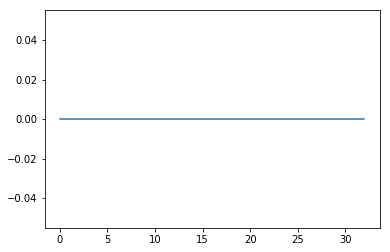

In [5]:
x= np.linspace(0,L,32//dx)
Vext = np.zeros(int(32/dx))
for i in range (int(32/dx)):
    Vext[i]=Vext_cal(i*L/32*dx,1,L/4,3)
plt.plot(x,Vext)


In [6]:
@jit
def distancesq(x1, x2):
    '''Gets the squared distance between two particles, applying the minimum image convention.'''
    # Calculate distances
    Dx = np.abs(x1-x2)
    if Dx > halfL:
        Dx -= L
    return Dx**2

In [7]:
@jit
def energy(particles,exist,epsilon,a,b,c):
    '''Gets the energy of the system'''
    energy = 0.
    
    for i in range(int(L)):
        for j in range(int(L)):
            if(i!=j and exist[i]*exist[j]==1):
                dist = distancesq(particles[i], particles[j])
                energy += 4.*epsilon*((1/dist**6)-(1/dist**3))
                if(dist<1):
                    print("Wrong!!!!")
    energy/=2
    
    for i in range(int(L)):
        if(exist[i]==1):
            energy+=Vext_cal(particles[i],a,b,c)
    
    return energy 

In [8]:
@jit
def particleEnergy(particle,p,exist, particles,epsilon,a,b,c):
    '''Gets the energy of a single particle.'''
    part_energy = 0.
    
    for i in range(int(L)):
        if(i!=p and exist[i]==1):
            dist = distancesq(particle, particles[i])
            if(dist<1):
                return 10**8
            part_energy += 4*epsilon*((1/dist**6)-(1/dist**3))
            
    
    part_energy+=Vext_cal(particle,a,b,c)
    
    return part_energy

In [9]:
# Initialize the simulation box:
@jit
def initial():
    particles = np.zeros(int(L))
    exist = np.zeros(int(L))
    for i in range(int(L)):
        #x_coord = random.uniform(0, L)
        particles[i]=i
        prop = random.uniform(0, 1)
        #if(prop>=0.5):
        #    exist[i]=1
    return particles,exist

In [10]:
@jit
def density_cal(particles,exist):
    n=int(L/dx)
    #dx=L/n
    #print(n,dx)
    rho = np.zeros(int(n),float)
    for i in range(int(L)):
        if(exist[i]==1):
            j=np.around(particles[i]//dx)
            rho[int(j)]+=1
    return rho/dx




In [11]:
@jit
def insertion(particles,z,exist,eps,a,b,c):
    for i in range (int(L)):
        if(exist[i]==0):
            particles[i] = random.uniform(0, L)
            ene = particleEnergy(particles[i],i,exist, particles,eps,a,b,c)
            prop = z*L/(np.sum(exist)+1)*np.exp(-ene)
            if(prop>=1):
                exist[i]=1
            elif(prop<1):
                dice = random.uniform(0, 1)
                if(dice<prop):
                    exist[i]=1
            break

@jit                   
def deletion(particles,z,exist,eps,a,b,c):
    M=np.random.randint(1,np.sum(exist)+1)
    cum_exist=np.cumsum(exist)
    for i in range (int(L)):
        if(exist[i]==1 and cum_exist[i]==M):
            ene = -particleEnergy(particles[i],i,exist, particles,eps,a,b,c)
            prop = np.sum(exist)/L/z*np.exp(-ene)
            if(prop>=1):
                exist[i]=0
            elif(prop<1):
                dice = random.uniform(0, 1)
                if(dice<prop):
                    exist[i]=0
            break
            

In [12]:
@jit
def MC_step(particles,z,exist,steps,eps,a,b,c,Print=True):
    for step in range(0, steps):
        prop = np.random.uniform(-0.5, 0.5)
        if(prop>0 and np.sum(exist)<L):
            insertion(particles,z,exist,eps,a,b,c)
        elif(np.sum(exist)>0):
            deletion(particles,z,exist,eps,a,b,c)
        if(step%100000==0 and Print==True):
            print(step,np.sum(exist))
    return particles,energy(particles,exist,eps,a,b,c) 

In [13]:
@jit
def MC_result(seed,z,eps,a,b,c):

    np.random.seed(seed)
    particles,exist = initial()
    "warm up"
    particles, energy = MC_step(particles,z,exist,1000,eps,a,b,c)
    avg_step = 10**5
    #avg_step = 10**3
    rho = density_cal(particles,exist)
    energy_avg=0
    N_avg=0
    ene_array = np.zeros(0)
    N_array = np.zeros(0)
    ene_array=np.append(ene_array,energy)
    N_array=np.append(N_array,np.sum(exist))
    for i in range(avg_step-1):
        np.random.seed(i)
        particles, ene = MC_step(particles,z,exist,1000,eps,a,b,c,Print=False)
        ene_array=np.append(ene_array,ene)
        N_array=np.append(N_array,np.sum(exist))
        rho += density_cal(particles,exist )
        if(i%10000==0):
            print(i,ene,np.sum(exist))
    rho=rho/avg_step
    print("energy_avg",np.sum(ene_array)/len(ene_array),
          np.sum(N_array)/len(N_array)/L)
    return rho, particles,ene_array,N_array


def density_result(seed,z,eps):
    """
    density = random.uniform(0.3,0.5)
    a=random.uniform(1,3)
    b=random.uniform(0,1)
    c=random.uniform(1,L/8)
    """
    a=0
    b=0
    c=0
    rho,particles,energy,N_array = MC_result(seed,z,eps,a,b,c)
    return rho,particles,energy,N_array

In [14]:
for i in range (9,-1,-1):
    eps= 0+i*0.5
    with open("eps_"+str(eps)[0:3]+"_mu_rho.dat",'w') as file:
        for j in range (0,100000):
            z=(0.01+j/10)**2/(1+eps)**2
            rho,particles,energy_array,N_array=density_result(123,z,eps)
            file.write(str(z)+"\t"+str(np.mean(rho))+"\t"+str(np.std(rho))+"\n")
            print(str(eps)+"\t"+str(z)+"\t"+str(np.mean(rho))+"\t"+str(np.std(rho))+"\n")
            if(np.mean(rho)>0.85):
                break;

0 0.0
0 0.0 0.0
10000 0.0 0.0
20000 0.0 0.0
30000 0.0 0.0
40000 0.0 0.0
50000 0.0 0.0
60000 0.0 0.0
70000 0.0 0.0
80000 0.0 0.0
90000 0.0 0.0
energy_avg 0.0 2.8125e-06
4.5	3.3057851239669424e-06	2.8125000000000006e-06	1.4733969042657853e-05

0 0.0
0 0.0 0.0
10000 0.0 0.0
20000 0.0 0.0
30000 0.0 0.0
40000 0.0 0.0
50000 0.0 0.0
60000 0.0 0.0
70000 0.0 0.0
80000 0.0 0.0
90000 0.0 0.0
energy_avg -0.00013409350545723258 0.0004040625
4.5	0.00039999999999999996	0.00040406250000000007	0.00017061212176674317

0 0.0
0 0.0 1.0
10000 0.0 0.0
20000 0.0 0.0
30000 0.0 0.0
40000 0.0 0.0
50000 0.0 0.0
60000 0.0 0.0
70000 0.0 0.0
80000 0.0 0.0
90000 0.0 0.0
energy_avg -0.004660545274980938 0.001535625
4.5	0.0014578512396694217	0.001535625	0.00034641861868987356

0 0.0
0 0.0 1.0
10000 0.0 0.0
20000 0.0 0.0
30000 0.0 0.0
40000 0.0 0.0
50000 0.0 0.0
60000 0.0 0.0
70000 0.0 0.0
80000 0.0 0.0
90000 0.0 0.0
energy_avg -0.02618793322111874 0.0035771875
4.5	0.0031768595041322314	0.0035771875	0.00055435060191520

energy_avg -103.62407950999291 0.827753125
4.5	0.17639999999999995	0.8277531250000001	0.06867764885852146

0 0.0
0 -87.58946084048458 26.0
10000 -81.53913880477101 23.0
20000 -99.92667237755916 25.0
30000 -98.10792414709462 26.0
40000 -103.49553704481636 27.0
50000 -95.69146827291993 26.0
60000 -89.00410737117092 25.0
70000 -97.13948884284281 25.0
80000 -107.36962716658167 27.0
90000 -100.36401732017806 26.0
energy_avg -104.41262496779613 0.83126
4.5	0.19200330578512392	0.8312599999999999	0.06971718045073251

0 1.0
0 -81.82144100216388 25.0
10000 -90.36563227880252 25.0
20000 -102.13880735730368 27.0
30000 -108.08638363012675 27.0
40000 -108.32094330222908 27.0
50000 -117.70373875034501 28.0
60000 -98.0880277653177 26.0
70000 -84.37413902436656 25.0
80000 -116.53887497085725 28.0
90000 -88.1929500318195 23.0
energy_avg -105.1228468245632 0.834399375
4.5	0.20826776859504129	0.8343993749999999	0.06056596032103656

0 1.0
0 -83.3060308906235 25.0
10000 -94.2990989103455 26.0
20000 -111.431

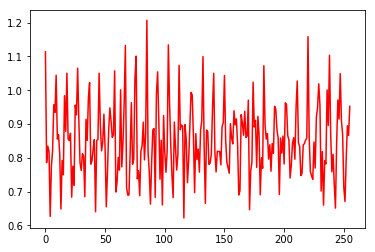

In [15]:
fig, ax1 = plt.subplots()
ax1.plot(rho,"r")

In [16]:
np.std(rho)

0.10930022862617614